# POC CNN Model based on VGG16 

In [1]:
#requisite imports, Use keras for quick prototyping

In [2]:
import numpy
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


### 1. Load Test and Train Files

In [3]:
files_train = 0
files_validation = 0

cwd = os.getcwd()
folder = 'train_data/train'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_train += len(files)


folder = 'train_data/test'
for sub_folder in os.listdir(folder):
    path, dirs, files = next(os.walk(os.path.join(folder,sub_folder)))
    files_validation += len(files)

print(files_train,files_validation)

381 164


### 2. Set key parameters

In [4]:
img_width, img_height = 48, 48
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"
nb_train_samples = files_train
nb_validation_samples = files_validation
batch_size = 32
epochs = 15
num_classes = 2

### 3. Build model on top of a trained VGG

In [5]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:10]:
    layer.trainable = False

W0814 15:32:38.670707 4530263488 deprecation_wrapper.py:119] From /Users/sumogroup/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 15:32:38.683143 4530263488 deprecation_wrapper.py:119] From /Users/sumogroup/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 15:32:38.685517 4530263488 deprecation_wrapper.py:119] From /Users/sumogroup/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 15:32:38.707700 4530263488 deprecation_wrapper.py:119] From /Users/sumogroup/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0814 15:32

In [6]:
x = model.output
x = Flatten()(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# creating the final model
model_final = Model(input = model.input, output = predictions)

# compile the model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"]) # See learning rate is very low

/Users/sumogroup/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.
W0814 15:32:39.234193 4530263488 deprecation_wrapper.py:119] From /Users/sumogroup/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [7]:
# Initiate the train and test generators with data Augumentation
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.1,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=5)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [8]:
# Save the model according to the conditions
checkpoint = ModelCheckpoint("car1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


In [9]:
### Start training!

history_object = model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [checkpoint, early])

/Users/sumogroup/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/Users/sumogroup/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=15, validation_data=<keras_pre..., callbacks=[<keras.ca..., steps_per_epoch=11, validation_steps=164)`
  if __name__ == '__main__':
W0814 15:32:39.613711 4530263488 deprecation.py:323] From /Users/sumogroup/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_

Epoch 1/15
11/11 [==============================] - 36s 3s/step - loss: 0.5912 - acc: 0.6449 - val_loss: 0.4196 - val_acc: 0.7959

Epoch 00001: val_acc improved from -inf to 0.79586, saving model to car1.h5
Epoch 2/15
11/11 [==============================] - 36s 3s/step - loss: 0.3476 - acc: 0.8193 - val_loss: 0.3003 - val_acc: 0.8840

Epoch 00002: val_acc improved from 0.79586 to 0.88402, saving model to car1.h5
Epoch 3/15
11/11 [==============================] - 36s 3s/step - loss: 0.2313 - acc: 0.9571 - val_loss: 0.2410 - val_acc: 0.8983

Epoch 00003: val_acc improved from 0.88402 to 0.89830, saving model to car1.h5
Epoch 4/15
11/11 [==============================] - 36s 3s/step - loss: 0.1753 - acc: 0.9514 - val_loss: 0.2220 - val_acc: 0.8967

Epoch 00004: val_acc did not improve from 0.89830
Epoch 5/15
11/11 [==============================] - 37s 3s/step - loss: 0.1509 - acc: 0.9509 - val_loss: 0.1902 - val_acc: 0.9121

Epoch 00005: val_acc improved from 0.89830 to 0.91207, saving

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


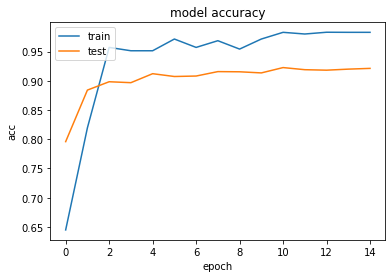

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history_object.history.keys())
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

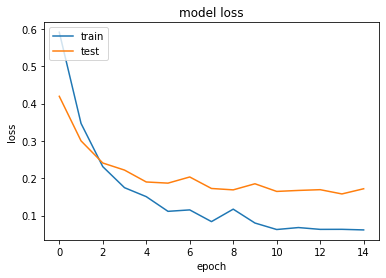

In [11]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()